In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sn
import itertools
from PIL import Image
from time import time
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve,PrecisionRecallDisplay
from sklearn.metrics import classification_report,matthews_corrcoef
from torch.utils.data import WeightedRandomSampler

In [ ]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using:', device)

Using: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Data/brain_tumor_dataset'
pretrain_dataset_path = '/content/drive/MyDrive/Data/brain_tumor_pretrain_dataset/Training'
mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
transform=transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=40),
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

pretrain_dataset = torchvision.datasets.ImageFolder(pretrain_dataset_path, transform = transform)
dataset = torchvision.datasets.ImageFolder(dataset_path, transform = transform)

pretrain_dataset, dummy_test_dataset = torch.utils.data.random_split(pretrain_dataset,(7010, 0))
train_dataset, test_dataset = torch.utils.data.random_split(dataset,(201, 40))


############################################# resampleing using weighted Random Sample on train_datset ##########################
y_train_indices = train_dataset.indices
y_train = [dataset.targets[i] for i in y_train_indices]
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
sample_weight = np.array([weight[t] for t in y_train])
sample_weight = torch.from_numpy(sample_weight)

sampler = WeightedRandomSampler(sample_weight.type('torch.DoubleTensor'), len(sample_weight))

##################################################################################################################################

pretrain_dataloader = torch.utils.data.DataLoader(
    dataset = pretrain_dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 2
)

train_dataloader = torch.utils.data.DataLoader(
    dataset = dataset,
    batch_size = 16,
    shuffle = False,
    sampler = sampler,
    num_workers = 2
)

test_dataloader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = 16,
    shuffle = False,
    num_workers = 2
)


In [ ]:
class CNN(nn.Module):
  def __init__(self, in_channel=3, num_classes=2):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding = 0)
    self.pool = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding = 0)
    self.bn2 = nn.BatchNorm2d(32)
    self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding = 0)
    self.bn3 = nn.BatchNorm2d(32)
    self.conv5 = nn.Conv2d(32, 64, kernel_size=3, padding = 0)
    self.bn4 = nn.BatchNorm2d(64)
    self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding = 0)
    self.bn5 = nn.BatchNorm2d(64)
    self.conv7 = nn.Conv2d(64, 128, kernel_size=3, padding = 0)
    self.bn6 = nn.BatchNorm2d(128)
    self.conv8 = nn.Conv2d(128, 128, kernel_size=3, padding = 1)
    self.bn7 = nn.BatchNorm2d(128)
    self.conv9 = nn.Conv2d(128, 128, kernel_size=3, padding = 1)
    self.bn8 = nn.BatchNorm2d(128)
    self.conv10 = nn.Conv2d(128, 256, kernel_size=3, padding = 2)
    self.bn9 = nn.BatchNorm2d(256)
    self.conv11 = nn.Conv2d(256, 256, kernel_size=3, padding = 2)
    self.bn10 = nn.BatchNorm2d(256)
    self.conv12 = nn.Conv2d(256, 256, kernel_size=3, padding = 2)
    self.bn11 = nn.BatchNorm2d(256)
    self.conv13 = nn.Conv2d(256, 256, kernel_size=3, padding = 2)
    self.bn12 = nn.BatchNorm2d(256)
    self.conv14 = nn.Conv2d(256, 256, kernel_size=3, padding = 2)
    self.bn13 = nn.BatchNorm2d(256)
    self.conv15 = nn.Conv2d(256, 256, kernel_size=3, padding = 2)
    self.bn14 = nn.BatchNorm2d(256)
    self.flatten = nn.Flatten()

    self.fc1 = nn.Linear(30976, 256)
    self.fc2 = nn.Linear(256, 2)
    self.bn1 = nn.BatchNorm1d(256)



  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)

    x = F.relu(self.conv3(x))
    x = self.bn2(x)
    x = F.relu(self.conv4(x))
    x = self.bn3(x)
    x = self.pool(x)

    x = F.relu(self.conv5(x))
    x = self.bn4(x)
    x = F.relu(self.conv6(x))
    x = self.bn5(x)
    x = self.pool(x)

    x = F.relu(self.conv7(x))
    x = self.bn6(x)
    x = F.relu(self.conv8(x))
    x = self.bn7(x)
    x = self.pool(x)

    x = F.relu(self.conv9(x))
    x = self.bn8(x)
    x = F.relu(self.conv10(x))
    x = self.bn9(x)
    x = self.pool(x)

    x = F.relu(self.conv11(x))
    x = self.bn10(x)
    x = F.relu(self.conv12(x))
    x = self.bn11(x)
    x = self.pool(x)

    x = F.relu(self.conv13(x))
    x = self.bn12(x)
    x = F.relu(self.conv14(x))
    x = self.bn13(x)
    x = F.relu(self.conv15(x))
    x = self.bn14(x)
    

    x = self.flatten(x)
    x = F.relu(self.fc1(x))

    x = self.bn1(x)
    x = self.fc2(x)
    return x

In [ ]:
def initialize_weights(m):
  if isinstance(m, nn.Conv2d):
      nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')
      if m.bias is not None:
          nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.BatchNorm2d):
      nn.init.constant_(m.weight.data, 1)
      nn.init.constant_(m.bias.data, 0)
  elif isinstance(m, nn.Linear):
      nn.init.kaiming_uniform_(m.weight.data)
      nn.init.constant_(m.bias.data, 0)

In [ ]:
model = CNN().to(device)
model.apply(initialize_weights)
print(model)
summary(model, (3,256,256))

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv8): Conv2d(128, 128, kernel_si

In [ ]:
def Pretrain(epoch, print_every=10):
    total_loss = 0
    start_time = time()

    accuracy = []
    for i, batch in enumerate(pretrain_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time
            ))

     
    return total_loss / len(pretrain_dataloader) # Returning Average Training Loss

In [ ]:
def Train(epoch, print_every=10):
    total_loss = 0
    start_time = time()

    accuracy = []
    for i, batch in enumerate(train_dataloader, 1):
        minput = batch[0].to(device) # Get batch of images from our train dataloader
        target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas

        moutput = model(minput) # output by our model

        loss = criterion(moutput, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters

        argmax = moutput.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target==argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor

        if i%print_every == 0:
            print('Epoch: [{}]/({}/{}), Train Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
                epoch, i, len(train_dataloader), loss.item(), sum(accuracy)/len(accuracy), time()-start_time
            ))

    return [(total_loss / len(train_dataloader)), (sum(accuracy) / len(accuracy))] # Returning Average Training Loss
    

In [ ]:
def Test(epoch):
    total_loss = 0
    start_time = time()
    

    accuracy = []

    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        model.eval()
        for i, batch in enumerate(test_dataloader):

            minput = batch[0].to(device) # Get batch of images from our test dataloader
            target = batch[1].to(device) # Get the corresponding target(0, 1 or 2) representing cats, dogs or pandas
            moutput = model(minput) # output by our model

            

            loss = criterion(moutput, target) # compute cross entropy loss
            total_loss += loss.item()


            # To get the probabilities for different classes we need to apply a softmax operation on moutput
            argmax = moutput.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)

            


            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets

    avg_testloss = total_loss/len(test_dataloader)
    avg_accuracy = sum(accuracy)/len(accuracy)
    print('Epoch: [{}], Test Loss: {:.4f}, Accuracy: {:.2f}, Time: {:.2f} sec'.format(
        epoch, total_loss/len(test_dataloader), sum(accuracy)/len(accuracy), time()-start_time
    ))

    return [avg_testloss, avg_accuracy] # Returning Average Testing Loss
    

In [ ]:
def freeze_layers(layers):
  for layer in layers:
    for param in layer.parameters():
      param.requires_grad = False
  print("layers freezed")

In [ ]:
lr = 0.0001
model = CNN().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


In [ ]:
pretrain_loss = []
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
layers=[model.conv7,model.conv8,model.conv9,model.conv10,model.conv11,model.conv12,model.conv13,model.fc1,model.fc2]
flag = 1

for epoch in range(1, 26):
   pretrain_loss.append(Pretrain(epoch,10))
   print("\n")

print("############################################################################################################")

Test(0)

for epoch in range(1, 151):
    

    train_loss1, train_accuracy1 = Train(epoch,10)
    train_loss.append(train_loss1)
    train_accuracy.append(train_accuracy1)
    test_loss1, test_accuracy1 = Test(epoch)
    test_loss.append(test_loss1)
    test_accuracy.append(test_accuracy1)
    if (train_loss1 <= 0.0020 or test_loss1 <= 0.0030) and flag == 1:
      print("############################################################################################################")
      freeze_layers(layers)
      flag = 0
      print("############################################################################################################")
    print('\n')
    

Epoch: [1]/(10/13), Train Loss: 1.0600, Accuracy: 0.56, Time: 59.84 sec
Epoch: [1]/(20/13), Train Loss: 0.7352, Accuracy: 0.61, Time: 78.78 sec
Epoch: [1]/(30/13), Train Loss: 0.5509, Accuracy: 0.65, Time: 98.21 sec
Epoch: [1]/(40/13), Train Loss: 0.3824, Accuracy: 0.69, Time: 114.95 sec
Epoch: [1]/(50/13), Train Loss: 0.3417, Accuracy: 0.72, Time: 135.16 sec
Epoch: [1]/(60/13), Train Loss: 0.2866, Accuracy: 0.73, Time: 154.03 sec
Epoch: [1]/(70/13), Train Loss: 0.3398, Accuracy: 0.74, Time: 175.53 sec
Epoch: [1]/(80/13), Train Loss: 0.4135, Accuracy: 0.75, Time: 195.65 sec
Epoch: [1]/(90/13), Train Loss: 0.4784, Accuracy: 0.75, Time: 213.33 sec
Epoch: [1]/(100/13), Train Loss: 0.4275, Accuracy: 0.76, Time: 232.20 sec
Epoch: [1]/(110/13), Train Loss: 0.5732, Accuracy: 0.76, Time: 254.93 sec
Epoch: [1]/(120/13), Train Loss: 0.2729, Accuracy: 0.77, Time: 273.21 sec
Epoch: [1]/(130/13), Train Loss: 0.2043, Accuracy: 0.77, Time: 290.68 sec
Epoch: [1]/(140/13), Train Loss: 0.3831, Accuracy:

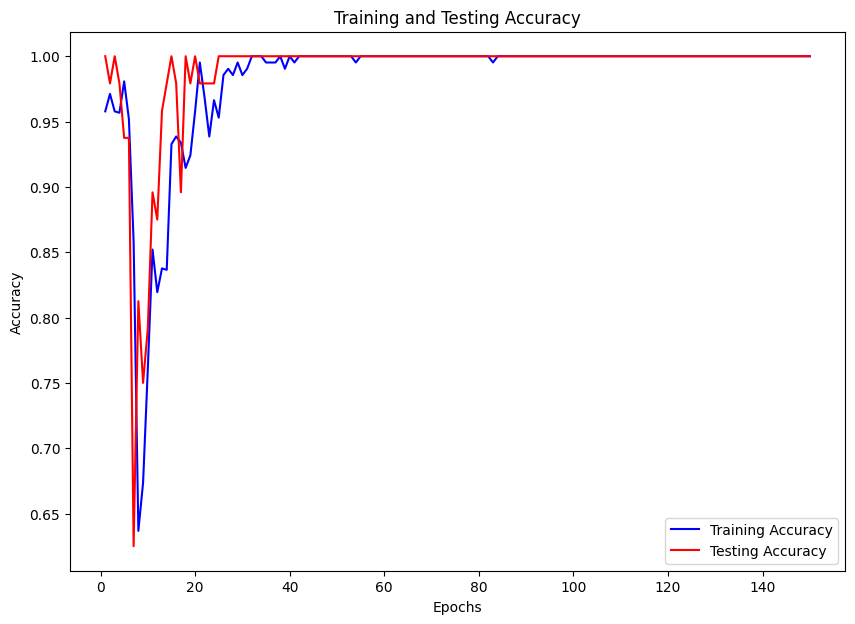

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(train_loss)+1), train_accuracy, 'b', label='Training Accuracy')
plt.plot(range(1, len(test_loss)+1), test_accuracy, 'r', label='Testing Accuracy')

plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

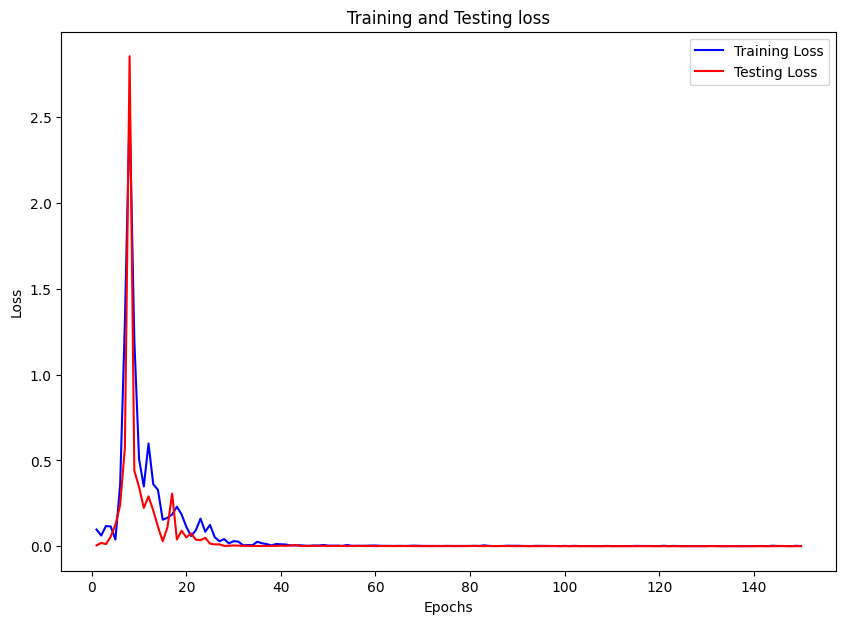

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(range(1, len(train_loss)+1), train_loss, 'b', label='Training Loss')
plt.plot(range(1, len(test_loss)+1), test_loss, 'r', label='Testing Loss')

plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
translate = {
    "no":"No Tumor",
    "yes":"Tumor",
}
translate = {x:translate[x] for x in train_dataloader.dataset.classes}


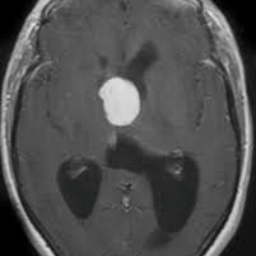

Tumor : 99 % 




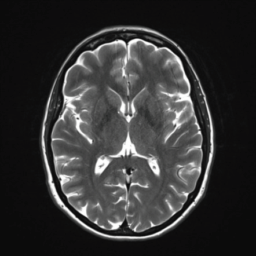

No Tumor : 99 % 




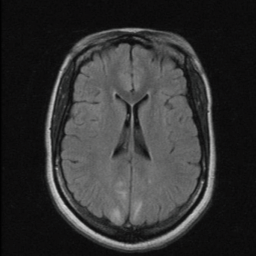

No Tumor : 99 % 




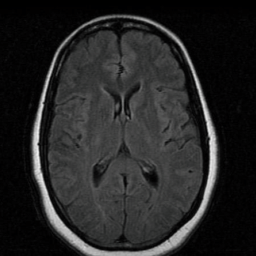

No Tumor : 99 % 




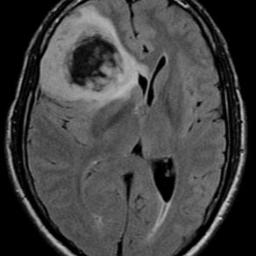

Tumor : 99 % 




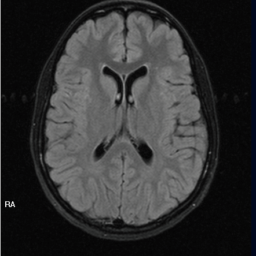

No Tumor : 99 % 




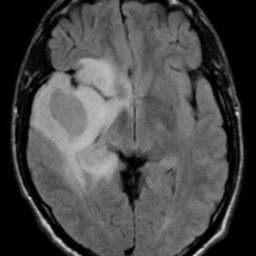

Tumor : 97 % 




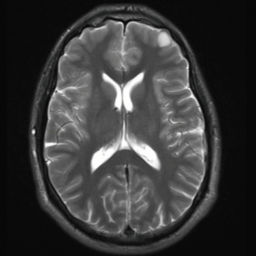

No Tumor : 99 % 




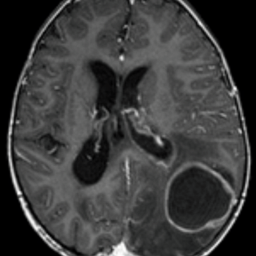

Tumor : 99 % 




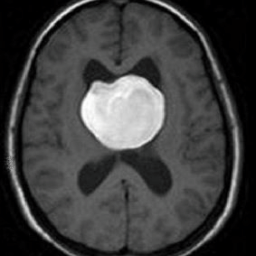

Tumor : 87 % 




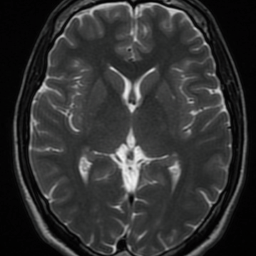

No Tumor : 99 % 




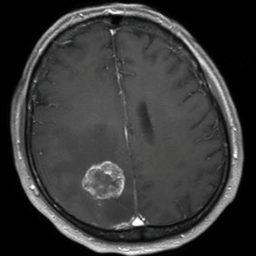

Tumor : 99 % 




In [ ]:
denormalize = transforms.Compose([
    transforms.Normalize(mean = -mean/std, std = 1./std),
    transforms.ToPILImage()
])


with torch.no_grad():

    for impath in os.listdir('/content/drive/MyDrive/Data/brain_tumor_test_dataset'): #change the path as per the requirement
        try:
            image = Image.open(f'/content/drive/MyDrive/Data/brain_tumor_test_dataset/{impath}').convert("RGB") #change the path as per the requirement
        except:
            continue

        image = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])(image)

        image_tensor = image.view(1,3,256,256).to(device)
        model.eval()
        moutput = model(image_tensor)
        moutput = nn.Softmax(dim=1)(moutput)[0]*100


        idx = moutput.argmax().data.item()
        oclass = list(translate.keys())[idx]
        moutput = moutput.int().data.cpu().numpy()

        display(denormalize(image))
        print(translate[oclass], ':', moutput[idx], '%', '\n\n')

model.train()
pass

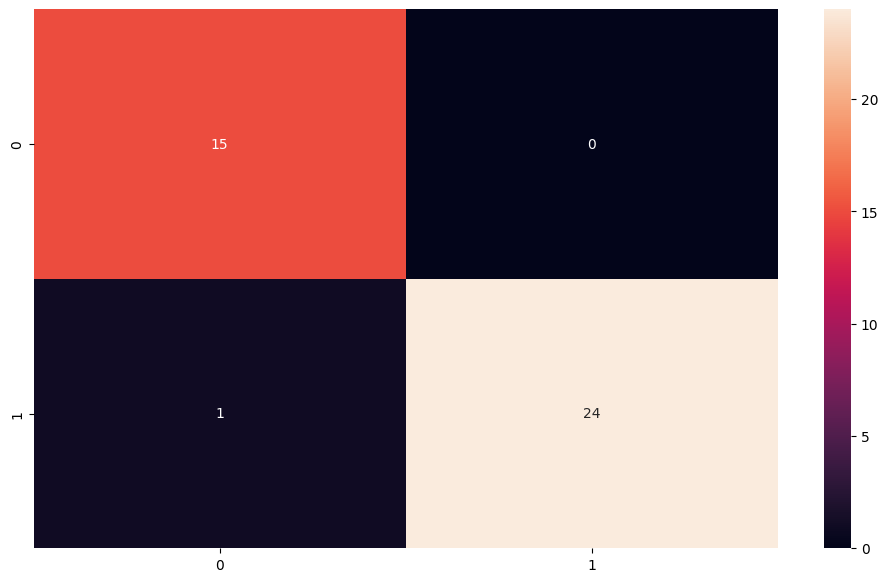

In [ ]:
y_pred = []
y_true = []
for inputs, labels in test_dataloader:
  output = model(inputs.cuda())
  output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
  y_pred.extend(output)

  labels = labels.data.cpu().numpy()
  y_true.extend(labels)

classes = ('Tumor', ' No Tumor')
cf_matrix = confusion_matrix(y_true, y_pred)
tn,fp,fn,tp = cf_matrix.ravel()
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))

sn.heatmap(cf_matrix, annot=True)
plt.savefig('output.png')


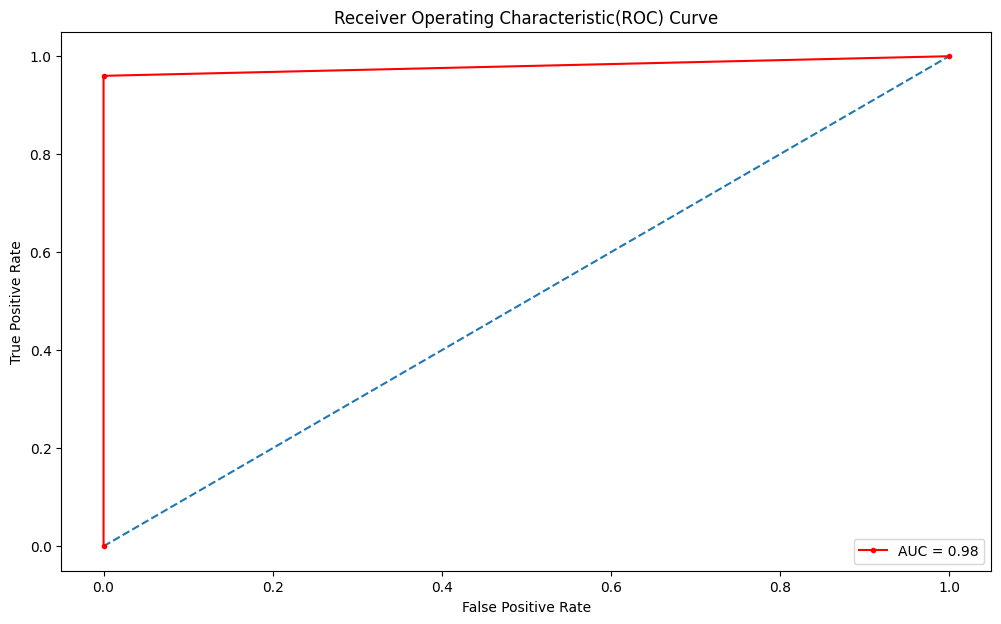

In [ ]:
ns_probs = [0 for _ in range(len(y_true))]
fpr,tpr,thresholds = roc_curve(y_true, y_pred)
ns_fpr,ns_tpr, thres = roc_curve(y_true, ns_probs)
auc = roc_auc_score(y_true, y_pred)
plt.figure(figsize=(12,7))
plt.plot(ns_fpr,ns_tpr, linestyle='--')
plt.plot(fpr, tpr, marker='.',color='red', label='AUC = '+str(auc))
plt.legend(loc=4)
plt.title("Receiver Operating Characteristic(ROC) Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('roc.png')

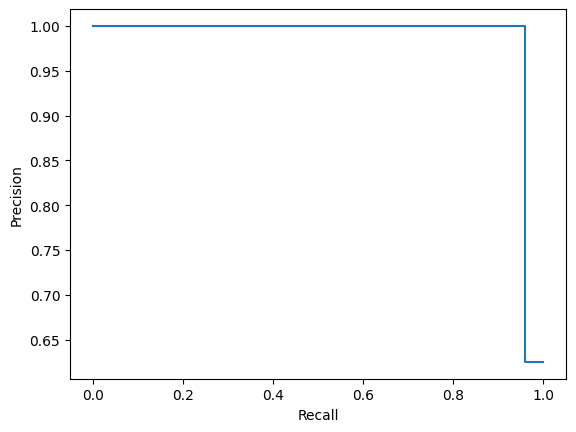

In [ ]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
disp=PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

In [ ]:
print("------------------------")
print("\n")
specificity = tn / (tn+fp)
print("Specificity = {0}".format(specificity))
print("\n")
sensitivity = tp / (tp+fn)
print("Sensitivity or Recall= {0}".format(sensitivity))
print("\n")
print("Accuracy = {0}".format((tp+tn) / (tp+fp+fn+tn)))
print("\n")
precision = tp / (tp+fp)
print("Precision = {0}".format(precision))
print("\n")
print("F1-Score = {0}".format(2 * ((precision * sensitivity)/(precision + sensitivity))))
print("\n")
print("J Score = {0}".format(sensitivity + specificity - 1))
print("\n")
print("Matthews correlation coefficient (MCC) = {0}".format(matthews_corrcoef(y_true, y_pred)))
print("\n")
print("------------------------")

------------------------


Specificity = 1.0


Sensitivity or Recall= 0.96


Accuracy = 0.975


Precision = 1.0


F1-Score = 0.9795918367346939


J Score = 0.96


Matthews correlation coefficient (MCC) = 0.9486832980505139


------------------------


In [ ]:
from sklearn.metrics import classification_report
cr = classification_report(y_true, y_pred, target_names = classes)
print(cr)

              precision    recall  f1-score   support

       Tumor       0.94      1.00      0.97        15
    No Tumor       1.00      0.96      0.98        25

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40

